In [32]:
from langchain_openai import OpenAIEmbeddings
from genu.Job_agent.config import HEADERS, LINKEDIN_JOB_SEARCH_PARAMS, PERSIST_PATH
from langchain.vectorstores import FAISS
from genu.Job_agent.vectorestore import vectorstore_to_dataframe

In [33]:
from dotenv import load_dotenv

load_dotenv()

True

In [34]:
from langchain_ollama import ChatOllama


base_url = "http://localhost:11434"
model = 'llama3.2'

llm = ChatOllama(base_url=base_url, model=model)
llm

ChatOllama(model='llama3.2', base_url='http://localhost:11434')

In [35]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-05-27T03:42:55.688323539Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7050470719, 'load_duration': 6552771031, 'prompt_eval_count': 32, 'prompt_eval_duration': 359960230, 'eval_count': 8, 'eval_duration': 133781643, 'model_name': 'llama3.2'}, id='run--5a2d4e6c-e719-436d-a2c8-7aa7beab4f05-0', usage_metadata={'input_tokens': 32, 'output_tokens': 8, 'total_tokens': 40})

In [36]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from tqdm import tqdm
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader

In [37]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the topic, 'yes' or 'no'"
    )


structured_llm_grader = llm.with_structured_output(GradeDocuments)

#! NOTE: update the system prompt for job search
system = """You are a grader assessing relevance of a retrieved document to a apply graduate. \n 
    Determine if this text is relevant to university applications based on these specific criteria:
    1. Content about professors (contact information, research interests, biographies, etc.)
    2. Information about graduate applications and programs (requirements, TOEFL/GRE scores, application processes)
    3. Details about research topics, including funding information
    4. Any other information that can be helpful for applying graduate
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to this topic."""
# system = """You are a grader assessing relevance of a retrieved document to a apply graduate. \n 
#     Any information that can be helpful for applying graduate students such as graduate programs, requirments for apply, departmenst information, \n
#     professors information, and any other information that can be helpful for applying graduate students should be mark as relevent. \n
#     Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to this topic."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader


In [38]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        documents: list of documents
    """
    documents: List[str]


In [39]:
# from typing import Any, Dict


# def retrieve(state: GraphState) -> Dict[str, Any]:
#     print("---RETRIEVE---")
#     loaded_vectorstore = FAISS.load_local(
#         f"../{PERSIST_PATH}",
#         OpenAIEmbeddings(),
#         allow_dangerous_deserialization=True,
#     )
#     # For FAISS

#     print("FAISS vectorstore count:", len(loaded_vectorstore.index_to_docstore_id))
    
#     return {"documents": loaded_vectorstore}

In [40]:
def retrieve(state: GraphState) -> Dict[str, Any]:
    """
    Load a FAISS vectorstore and return all documents as a list.

    Args:
        persist_directory (str): Directory where the FAISS index is stored
        embeddings (optional): Embedding function, defaults to OpenAIEmbeddings if None

    Returns:
        list: List of Document objects from the vectorstore
    """
    print("---RETRIEVE---")
    # Load the vectorstore
    try:
        vectorstore = FAISS.load_local(
            f"../{PERSIST_PATH}",
            OpenAIEmbeddings(),
            allow_dangerous_deserialization=True
        )
        print(f"Loaded FAISS index with {len(vectorstore.index_to_docstore_id)} documents.")
    except Exception as e:
        print(f"Error loading vectorstore: {e}")
        return []  # Return empty list on error

    # Extract all documents into a list
    documents = []
    for doc_id in vectorstore.index_to_docstore_id.values():
        doc = vectorstore.docstore.search(doc_id)
        if doc:
            documents.append(doc)

    print(f"Retrieved {len(documents)} documents from vectorstore.")
    return {"documents": documents} 

In [41]:
def grade_documents(state: GraphState) -> Dict[str, Any]:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    documents = state["documents"]

    filtered_docs = []
    for d in tqdm(documents):
        score = retrieval_grader.invoke(
            {"document": d.page_content}
        )
        grade = score.binary_score
        if grade.lower() == "yes":
            # print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            # print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    print(f"Number of relevant documents: {len(filtered_docs)}")
    return {"documents": filtered_docs, }


In [42]:
from langgraph.graph import StateGraph, END
graph = StateGraph(GraphState)
graph.add_node("retrieve", retrieve)
graph.add_node("grade_documents", grade_documents)
graph.add_edge("retrieve", "grade_documents")
graph.add_edge("grade_documents", END)

graph.set_entry_point("retrieve")

filter_graph = graph.compile()

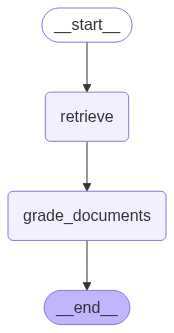

In [43]:
filter_graph

In [44]:
filter_graph.invoke(input={})

---RETRIEVE---
Loaded FAISS index with 180 documents.
Retrieved 180 documents from vectorstore.
---CHECK DOCUMENT RELEVANCE TO QUESTION---


 14%|█▍        | 26/180 [00:16<01:36,  1.60it/s]


KeyboardInterrupt: 